# Domain of Applicability of Noisy Third Degree Polynomial
### Mario Boley, Department of Data Science and AI, Monash University

In this notebook we reproduce and build on the example of [Fig. 1](https://www.nature.com/articles/s41467-020-17112-9/figures/1) of [Sutton et al. 2020](https://www.nature.com/articles/s41467-020-17112-9) using the subgroup discovery module of realkd.py.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split

RNG = np.random.default_rng(seed = 0)

## Data and Sampling Distribution

\begin{align*}
X_1 &\sim N(0, 2) \\
X_2 &\sim N(0, 2) \\
Y &\sim X_1^3 - X_1 + N(\exp(X_2 / 2))
\end{align*}

In [2]:
def f(x1, x2):
    return x1**3 - x1

def var(x1, x2):
    return np.exp(x2/2)

def data(n):
    x = RNG.multivariate_normal([0, 0], [[2, 0], [0, 2]], n)
    y = f(x[:, 0], x[:, 1]) + RNG.normal(0, var(x[:, 0], x[:, 1]))
    return x, y

In [3]:
n = 1000
test_size = 0.2

x, y = data(n)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=False)

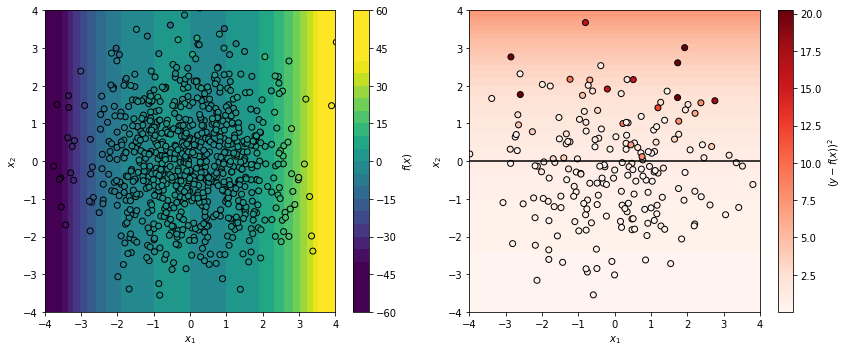

In [5]:
e_train = y_train-f(*x_train.T)
e_test = y_test-f(*x_test.T)
e_min = min(e_train.min(), e_test.min())
e_max = min(e_train.max(), e_test.max())

xx1, xx2 = np.meshgrid(np.linspace(-4, 4, 200), np.linspace(-4, 4, 200))
ff = f(xx1, xx2)
se_expect = var(xx1, xx2)
se_test=(f(*x_test.T) - y_test)**2

def format_axes():
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cp = plt.contourf(xx1, xx2, ff, levels=25, vmin=-40, vmax=40)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, vmin=-40, vmax=40, edgecolors='black')
plt.colorbar(cp, label='$f(x)$')
format_axes()

plt.subplot(1, 2, 2)
se_max_mean = (se_expect.max() + se_test.max())/2
cp = plt.contourf(xx1, xx2, se_expect, cmap='Reds', levels=25, vmax=se_max_mean)
sc = plt.scatter(x_test[:,0], x_test[:,1], c=se_test, edgecolors='black', cmap='Reds', vmax=se_max_mean)
plt.contour(xx1, xx2, se_expect, levels=[1], colors='black')
plt.colorbar(sc, label='$(y - f(x))^2$')
format_axes()

plt.tight_layout()
plt.show()

## Gaussian Kernel Model

In [6]:
rbf = KernelRidge(kernel='rbf').fit(x_train, y_train)
yhat_test = rbf.predict(x_test)
abs_res_test = abs(yhat_test - y_test)
abs_res_test.mean()

1.522743259602654

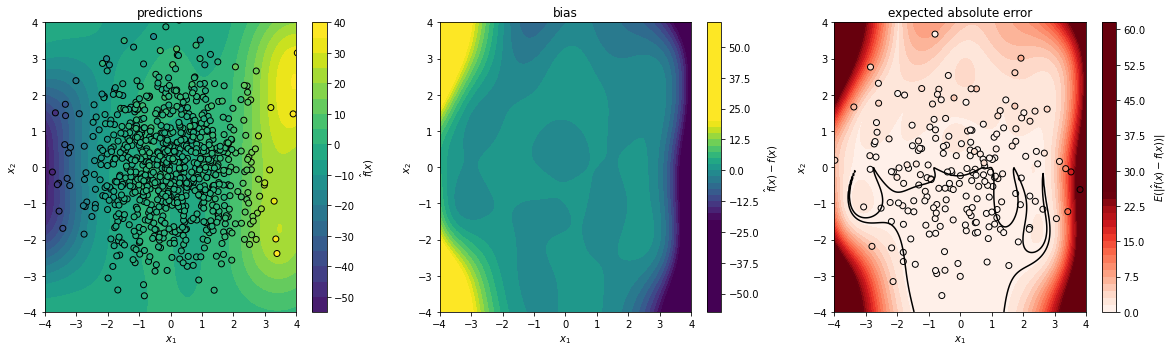

In [7]:
# xx1, xx2 = np.meshgrid(np.linspace(-5, 5, 200), np.linspace(-5, 5, 200))
yy = rbf.predict(np.column_stack([xx1.ravel(), xx2.ravel()]))
yy = yy.reshape(xx1.shape)

rbf_bias = yy - ff
rbf_ese = rbf_bias**2 + se_expect

ae = abs(yy - (xx1**3 - xx1))
eae = ae + var(xx1, xx2)**0.5

vmin  = min(yy.min(), ff.min())
vmax  = min(yy.max(), ff.max())

plt.figure(figsize=(16.5, 5))
plt.subplot(1, 3, 1)
plt.title('predictions')
cp = plt.contourf(xx1, xx2, yy, levels=20, vmin=vmin, vmax=vmax)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='black', vmin=vmin, vmax=vmax)
plt.colorbar(cp, label=r'$\hat{f}(x)$')
format_axes()

plt.subplot(1, 3, 2)
plt.title('bias')
cp = plt.contourf(xx1, xx2, rbf_bias, levels=50, vmin=-20, vmax=20)#, vmax=ae.max())
# plt.scatter(x_test[:, 0], x_test[:, 1], c=abs(rbf.predict(x_test)-y_test), cmap='Reds', edgecolors='black', vmin=0, vmax=ae.max())
plt.colorbar(cp, label=r'$\hat{f}(x)-f(x)$')
format_axes()

plt.subplot(1, 3, 3)
plt.title('expected absolute error')
plt.contour(xx1, xx2, eae, levels=[1], colors='black', linestyles='-')
cp = plt.contourf(xx1, xx2, eae, levels=50, cmap='Reds', vmin=0, vmax=25)
plt.scatter(x_test[:, 0], x_test[:, 1], c=abs(rbf.predict(x_test) - y_test), edgecolors='black', vmin=0, vmax=25, cmap='Reds')
plt.colorbar(cp, label=r'$E(|\hat{f}(x)-f(x))|$')
format_axes()

plt.tight_layout()
plt.show()

## Domain of Applicability Identification

In [10]:
x_idn, y_idn = x_test[160:], y_test[160:]
x_val, y_val = x_test[:160], y_test[:160]

e_idn = (y_idn - rbf.predict(x_idn))**2
e_idn

array([2.43874360e-01, 2.85114382e-02, 6.91335169e-02, 2.16964905e-01,
       5.70733262e+00, 2.00448719e+00, 3.29433481e-01, 5.14194493e+00,
       2.92424081e+00, 3.74232349e-03, 5.55870758e-01, 5.56771989e-03,
       6.84400264e-01, 1.40376192e-02, 1.45779740e+00, 1.08089307e+01,
       3.46110542e-01, 3.91810917e-02, 4.51522677e-01, 1.85866979e+00,
       4.18012012e-02, 2.20094579e-01, 1.23407977e+01, 1.56548633e-01,
       6.38531673e-01, 1.59077174e+01, 1.47203050e-01, 1.33309378e+00,
       2.25582448e-01, 3.64256039e-01, 8.09507852e+00, 1.91886276e-01,
       4.13054577e-01, 1.71227170e-01, 1.22316822e+00, 2.25889908e+01,
       4.40218580e-01, 6.10598176e+00, 6.82568246e-02, 8.24828228e-01])

In [17]:
from realkd.subgroups import ImpactRuleEstimator
x_idn_pd=pd.DataFrame(x_idn, columns=['x1', 'x2'])
e_idn_pd=pd.Series(e_idn)

# x_idn_pd
doa_rbf = ImpactRuleEstimator(alpha=0.1, search='greedy', search_params={'max_col_attr':20}).fit(x_idn_pd, -e_idn_pd)
doa_rbf.rule_

   -0.1886 if x1<=1.0977542141780825 & x1>=-1.498350215485505 & x2<=-0.20759731340634274